In [36]:
#!source ../activate_conda.sh
import processor.fake_rate_measurement as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *

In [4]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset

overwrite = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018

samples = get_samples()

fileset = make_fileset(['QCD'], samples, redirector=redirector_ucsd, small=True)

add_processes_to_output(fileset, desired_output)

desired_output.update({
    "single_mu_fakeable": hist.Hist("Counts", dataset_axis, pt_axis, eta_axis),
    "single_mu": hist.Hist("Counts", dataset_axis, pt_axis, eta_axis)
})

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        fr.nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()


In [5]:
fakeable_mu_hist = output["single_mu_fakeable"]
mu_hist = output["single_mu"]

In [7]:
type(fakeable_mu_hist)

coffea.hist.hist_tools.Hist

<AxesSubplot:xlabel='$eta\\ (GeV)$', ylabel='$p_{T}\\ (GeV)$'>

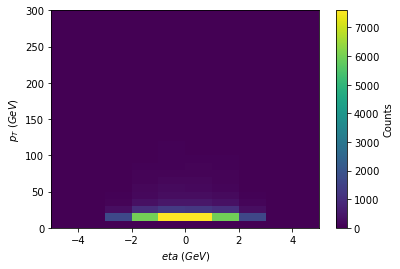

In [25]:
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
eta_bins = hist.Bin('eta', r'$eta\ (GeV)$', 10, -5, 5)
rebinned_fakeable_mu_hist = fakeable_mu_hist.rebin('pt', pt_bins).rebin('eta', eta_bins)
hist.plot2d(rebinned_fakeable_mu_hist.sum("dataset"), xaxis="eta")

<AxesSubplot:xlabel='$eta\\ (GeV)$', ylabel='$p_{T}\\ (GeV)$'>

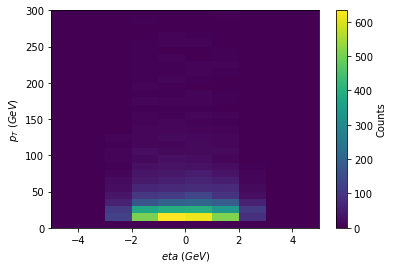

In [24]:
rebinned_mu_hist = mu_hist.rebin('pt', pt_bins).rebin('eta', eta_bins)
hist.plot2d(rebinned_mu_hist.sum("dataset"), xaxis="eta")

<AxesSubplot:xlabel='$eta\\ (GeV)$', ylabel='$p_{T}\\ (GeV)$'>

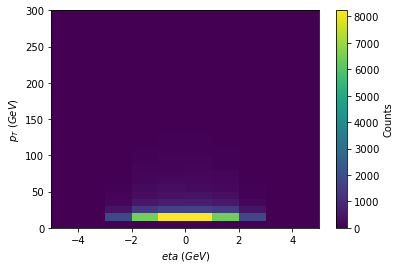

In [32]:
f_plus_t = rebinned_mu_hist + rebinned_fakeable_mu_hist
hist.plot2d(f_plus_t.sum("dataset"), xaxis="eta")

In [73]:
a = rebinned_mu_hist
b = rebinned_fakeable_mu_hist

In [ ]:

Loose_Muon = Hist2D.from_bincounts(
    combine_mat(QCD[0]['Muon'].sum().values()).T,
    (QCD[0]['Muon'].axis('pt').edges(), QCD[0]['Muon'].axis('eta').edges())
)

In [111]:
#print(a.sum("dataset").values()[()].T.T)
print(a.sum('dataset').axes()[0])
print(dir(a))

<Bin (name=pt) instance at 0x7fa3d15948b0>
['DEFAULT_DTYPE', '__abstractmethods__', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_axes', '_dense_shape', '_dtype', '_idense', '_init_sumw2', '_isparse', '_label', '_sumw', '_sumw2', 'add', 'axes', 'axis', 'clear', 'compatible', 'copy', 'dense_axes', 'dense_dim', 'dim', 'fields', 'fill', 'group', 'identifiers', 'identity', 'integrate', 'label', 'project', 'rebin', 'remove', 'scale', 'sparse_axes', 'sparse_dim', 'sparse_nbins', 'sum', 'to_boost', 'to_hist', 'values']


In [115]:
# num = Hist2D.from_bincounts(b.sum('dataset').values()[()].T, (b.axis('pt').edges(), b.axis('eta').edges()))
# denom = Hist2D.from_bincounts((a+b).sum('dataset').values()[()].T, ((a+b).axis('pt').edges(), (a+b).axis('eta').edges()))
num = b.sum('dataset')
denom = (a+b).sum('dataset')

In [132]:
def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)

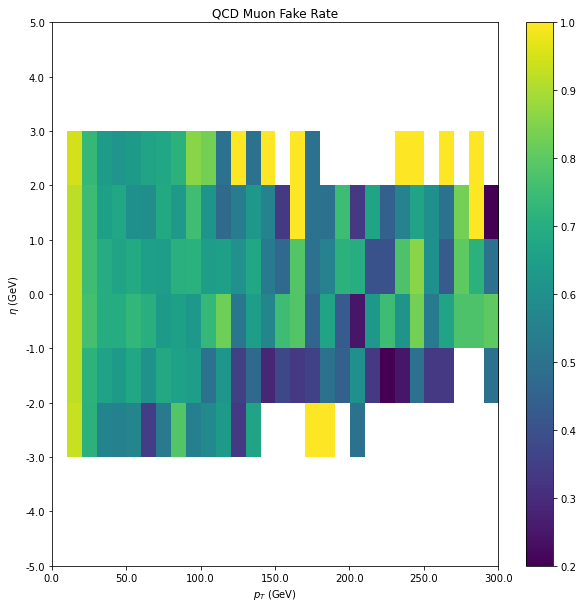

In [134]:
plt.figure("test_plot", figsize = (10,10))
divide_2D_hist(num, denom).plot(show_counts=False, equidistant='xy')
plt.xticks([0, 50, 100, 150, 200, 250, 300])
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel(r'$\eta$ (GeV)')
plt.title('QCD Muon Fake Rate')
plt.show()

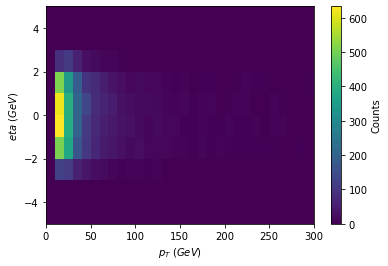

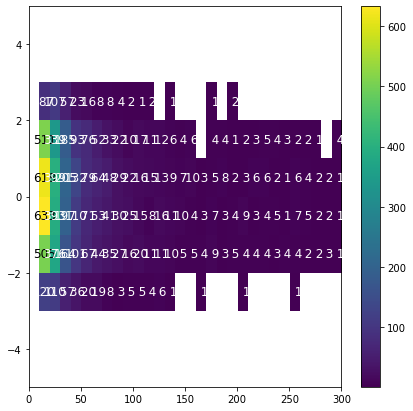

In [131]:
x1 = a.sum('dataset')
x1_axis_0 = x1.axes()[0].name
x1_axis_1 = x1.axes()[1].name
x1_y = Hist2D.from_bincounts(x1.values()[()].T, (x1.axis(x1_axis_0).edges(), x1.axis(x1_axis_1).edges()))
hist.plot2d(x1, xaxis = x1.axes()[0].name)
plt.figure('test2', figsize = (7,7))
x1_y.plot(show_counts=True)
plt.draw()